<a href="https://colab.research.google.com/github/saquibali7/MultiModalHateSpeeechDetection/blob/main/HateSpeechDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
import pytesseract
import shutil
import random
from pytesseract import pytesseract
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,  random_split
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torchtext
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
HateSpeech = "/content/drive/MyDrive/hateSpeechDetection/Hate Speech"
NoHateSpeech = "/content/drive/MyDrive/hateSpeechDetection/No Hate Speech"

HateSpeechText = "/content/drive/MyDrive/CASE2023_TASK4_TrainData/subTaskA/Hate Speech"
NoHateSpeechText = "/content/drive/MyDrive/CASE2023_TASK4_TrainData/subTaskA/No Hate Speech"


In [ ]:
HateImages = os.listdir(HateSpeech)
NotHateImages = os.listdir(NoHateSpeech)
print(len(HateImages), len(NotHateImages))

1942 1658


In [ ]:
def extract_text(path):
  image_path=path
  extractedInformation = pytesseract.image_to_string(Image.open(image_path))
  return extractedInformation



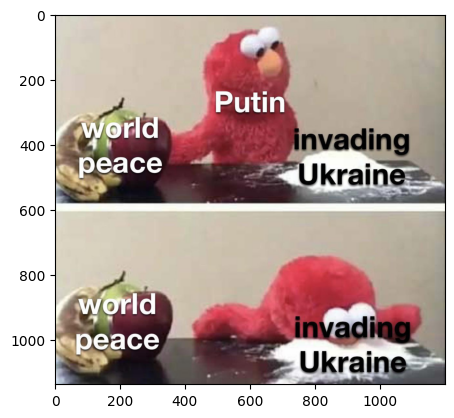

In [ ]:
images = os.listdir(HateSpeech)
idx = random.randint(0,len(images))
img_path = os.path.join(HateSpeech,images[idx])
img = Image.open(img_path)
img = np.array(img)
plt.imshow(img)

text = extract_text(img_path)
print(text)

In [ ]:
!pip install transformers

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)


In [ ]:
!pip install torch torchvision transformers

In [ ]:
!pip install sentencepiece

In [ ]:
xlnet_tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths,label, transform=None,
                 xlnet_tokenizer=None,bert_tokenizer=None,max_len=1024):
      self.image_paths = image_paths
      self.label = label
      self.max_len = max_len
      self.bert_tokenizer = bert_tokenizer
      self.xlnet_tokenizer = xlnet_tokenizer
      self.transform=transform

    def __len__(self):
      return len(os.listdir(self.image_paths))

    def __getitem__(self, idx):
      try:
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.label
        extracted_text = extract_text(self.image_paths[idx])
        if self.transform:
          image = self.transform(image)

        bert_encoding = self.bert_tokenizer.encode_plus(
                                text = extracted_text,
                                add_special_tokens = True,
                                max_length = self.max_token_len,
                                return_token_type_ids = False,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask = True,
                                return_tensors='pt',
                                # is_split_into_words=True
                        )

        xlnet_encoding = self.xlnet_tokenizer.encode_plus(
                                text = extracted_text,
                                add_special_tokens = True,
                                max_length = self.max_token_len,
                                return_token_type_ids = False,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask = True,
                                return_tensors='pt',
                                # is_split_into_words=True
                        )
        return image, label, bert_encoding, xlnet_encoding
      except:
        print("error")




In [ ]:
batch_size = 16
learning_rate = 0.001
num_epochs = 10
num_features = 512
num_classes=2

dataset1 = CustomDataset(HateSpeech,1,transform,xlnet_tokenizer, bert_tokenizer)
dataset2 = CustomDataset(NoHateSpeech,0,transform,xlnet_tokenizer, bert_tokenizer)

combined_dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
train_ratio = 0.8
dataset_size = len(combined_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class InceptionNetModel(nn.Module):
    def __init__(self, num_features):
        super(InceptionNetModel, self).__init__()
        self.inceptionnet_model = models.inception_v3(pretrained=True)
        self.inceptionnet_model.fc = nn.Linear(self.inceptionnet_model.fc.in_features, num_features)

    def forward(self, x):
        return self.inceptionnet_model(x)

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, image_model, text_model_xlnet, text_model_bert, num_classes):
        super(EnsembleModel, self).__init__()
        self.image_model = image_model
        self.text_model_xlnet = text_model_xlnet
        self.text_model_bert = text_model_bert
        self.fc = nn.Linear(
            image_model.inceptionnet_model.fc.out_features +
            text_model_xlnet.config.hidden_size +
            text_model_bert.config.hidden_size,
            num_classes
        )

    def forward(self, img, txt_xlnet, txt_bert):
        img_feat = self.image_model(img)
        txt_feat_xlnet = self.text_model_xlnet(**txt_xlnet).last_hidden_state.mean(dim=1)
        txt_feat_bert = self.text_model_bert(**txt_bert).last_hidden_state.mean(dim=1)

        combined_feat = torch.cat((img_feat, txt_feat_xlnet, txt_feat_bert), dim=1)
        return self.fc(combined_feat)


In [ ]:
inception_model = InceptionNetModel(num_features)
xlnet = transformers.XLNetModel.from_pretrained("xlnet-base-cased")
bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

ensemble_model = EnsembleModel(inception_model, xlnet, bert, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for image, label, text_xlnet, text_bert in train_loader:
        outputs = ensemble_model(images, text_xlnet, text_bert)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
def train_one_epoch(model,dataloader):
    model = ensemble_model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0

    actuals, predictions = [], []

    loop = tqdm(dataloader, total=len(dataloader),desc='Train')

    for b , image, label, bert_encoding, xlnet_encoding in enumerate(loop):
        image = image.to(device)
        image = image.float()
        encoding0 = bert_encoding.to(device)
        encoding1 = xlnet_encoding.to(device)
        label = label.to(device)

        out = model(image,encoding0,encoding1)
        cur_train_loss = criterion(out, label)
        actuals.extend(label.cpu().numpy().astype(int))
        predictions.extend(F.softmax(out, 1).cpu().detach().numpy())
        cur_train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += cur_train_loss.item()

    scheduler.step()

    predictions = np.array(predictions)
    predicted_labels = predictions.argmax(1)
    accuracy = (predicted_labels == actuals).mean()

    return train_loss/len(dataloader) , accuracy

def valid_one_epoch(model,dataloader):

    model = model.to(device)

    val_loss = 0
    val_acc = 0
    actuals, predictions = [], []

    model.eval()
    with torch.no_grad():

        loop = tqdm(dataloader, total=len(dataloader),desc='Valid')

        for b , image, label, bert_encoding, xlnet_encoding in enumerate(loop):
            image = image.to(device)
            image = image.float()
            encoding0 = bert_encoding.to(device)
            encoding1 = xlnet_encoding.to(device)
            label = label.to(device)

            out = model(image,encoding0,encoding1)

            actuals.extend(label.cpu().numpy().astype(int))
            predictions.extend(F.softmax(out, 1).cpu().detach().numpy())

            cur_valid_loss = criterion(out, label)
            val_loss += cur_valid_loss.item()


    predictions = np.array(predictions)
    predicted_labels = predictions.argmax(1)
    accuracy = (predicted_labels == actuals).mean()

    return val_loss/len(dataloader) ,accuracy


NUM_EPOCHS = 50
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0


for epoch in range(NUM_EPOCHS):

    train_loss , train_acc = train_one_epoch(model=ensemble_model, dataloader=train_loader)
    val_loss , val_acc = valid_one_epoch(model=ensemble_model, dataloader=test_loader)

    print(f"\n Epoch:{epoch + 1} / {NUM_EPOCHS},train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")


    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
      torch.save(ensemble_model.state_dict(),'best_xlent.pth')
